reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining 

    r = Δx/ℓ   Δx  N (samples)  RMSE_floor_true  RMSE_floor_marg  \
0        0.2  0.2          101         0.000000         0.000000   
1        0.5  0.5           41         0.000026         0.000102   
2        0.9  0.9           23         0.031043         0.042696   
3        1.2  1.2           17         0.133003         0.248792   
4        1.6  1.6           13         0.314924         0.518121   
5        1.9  1.9           11         0.443250         0.683482   
6        2.5  2.5            9         0.646351         0.759494   
7        3.0  3.0            7         0.768126         0.768378   
8        4.0  4.0            6         0.929753         0.842467   
9        5.0  5.0            5         1.029364         0.953187   
10       9.0  9.0            3         1.205852         1.205852   

    RMSE_floor_fit  RMSE_mean  RMSE_std  
0         0.000000   0.032232  0.006987  
1         0.000048   0.030333  0.005931  
2         0.032633   0.057804  0.014830  
3         0.159

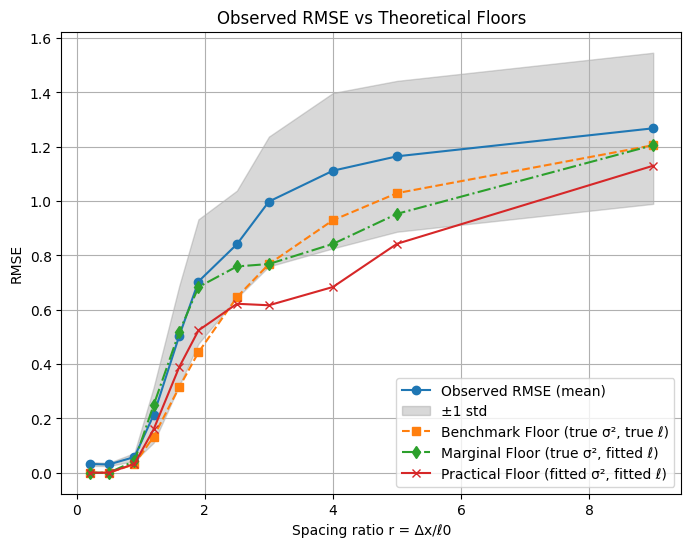

In [1]:
# -----------------------------
# error floor figure
# -----------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, pi
from mpmath import erfc
import GPy
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6
n_trials = 100

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]
r_values = [0.2, 0.5, 0.9, 1.2, 1.6, 1.9, 2.5, 3.0, 4.0, 5.0, 9.0]

results = []
for r in r_values:
    dx = r * ell_true
    N = int(np.floor(L / dx)) + 1
    X_sub = np.linspace(left, right, N)[:, None]

    rmse_trials = []
    fitted_ells = []
    fitted_vars = []

    for t in range(n_trials):
        # --- Simulate one GP realization ---
        k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
        K_true = k_true.K(X, X) + noise*np.eye(n_fine)
        Y = np.random.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

        # Subsample observations
        idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
        Y_sub = Y[idx]

        # --- Fit GP ---
        k_fit = GPy.kern.RBF(input_dim=1)
        m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
        m.Gaussian_noise.variance.constrain_bounded(1e-6, 1e-3)  # small nugget >0
        m.rbf.lengthscale.constrain_bounded(0.05, 10.0)
        m.rbf.variance.constrain_bounded(0.1, 10.0)
        m.optimize(messages=False)

        mu, var = m.predict(X)
        rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))
        rmse_trials.append(rmse)
        fitted_ells.append(float(m.rbf.lengthscale))
        fitted_vars.append(float(m.rbf.variance))

    # --- Theory with true ℓ & true σ² ---
    z = pi / (sqrt(2) * r)
    epsilon_true = float(erfc(z))
    eps_rmse_true = np.sqrt(epsilon_true * var_true)

    # --- Floor using fitted ℓ (marginalized), but true σ² ---
    eps_marg = np.mean([float(erfc(pi/(sqrt(2)*r) * (ell_hat/ell_true)))
                        for ell_hat in fitted_ells])
    eps_rmse_marg = np.sqrt(eps_marg * var_true)

    # --- Floor using fitted ℓ AND fitted σ² ---
    eps_rmse_fit = np.mean([
        np.sqrt(float(erfc(pi/(sqrt(2)*r) * (ell_hat/ell_true))) * var_hat)
        for ell_hat, var_hat in zip(fitted_ells, fitted_vars)
    ])

    # --- Observed RMSE ---
    rmse_mean = np.mean(rmse_trials)
    rmse_std = np.std(rmse_trials)

    results.append({
        "r = Δx/ℓ": r,
        "Δx": dx,
        "N (samples)": N,
        "RMSE_floor_true": eps_rmse_true,
        "RMSE_floor_marg": eps_rmse_marg,
        "RMSE_floor_fit": eps_rmse_fit,
        "RMSE_mean": rmse_mean,
        "RMSE_std": rmse_std
    })

# -----------------------------
# Save results
# -----------------------------
df = pd.DataFrame(results)
df.to_csv("gp_results_with_var.csv", index=False)
print(df.round(6))

# -----------------------------
# Plot with three floors
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(df["r = Δx/ℓ"], df["RMSE_mean"], 'o-', label="Observed RMSE (mean)")
plt.fill_between(df["r = Δx/ℓ"],
                 df["RMSE_mean"]-df["RMSE_std"],
                 df["RMSE_mean"]+df["RMSE_std"],
                 color="gray", alpha=0.3, label="±1 std")

plt.plot(df["r = Δx/ℓ"], df["RMSE_floor_true"], 's--', label="Benchmark Floor (true σ², true ℓ)")
plt.plot(df["r = Δx/ℓ"], df["RMSE_floor_marg"], 'd-.', label="Marginal Floor (true σ², fitted ℓ)")
plt.plot(df["r = Δx/ℓ"], df["RMSE_floor_fit"], 'x-', label="Practical Floor (fitted σ², fitted ℓ)")

plt.xlabel("Spacing ratio r = Δx/ℓ0")
plt.ylabel("RMSE")
plt.title("Observed RMSE vs Theoretical Floors")
plt.grid(True)
plt.legend()
plt.savefig("gp_lineplot_rmse_with_var.png", dpi=200, bbox_inches="tight")
plt.show()